# Introduction

The Masters is the biggest Golf tournament in the world. Every golfer dreams of merely competing in the selective tournament. As a result, the tournament is one of the fan favorites. I am enamored with the Masters and have it on my bucket list to go watch the event some day. 

So, for this project I decided to dive into the Masters a little more. Specifically, I wanted to see if I would be able to predict whether a golfer would finish in the top 10 of the masters (fun fact, 10th place recieves $230,000). I recognize that this project does not solve a serious problem and is not the most useful problem, but it's one of interest to me and as a fan of the sport I feel that this will enhance my viewing experience. 

In order to predict who will finish in the top ten of the Masters I need some statistics. Luckily, the Professional Golf Association (PGA) maintains lots of statistics that are readily available for the public. In addition to the statistics I need to pull results from previous Masters tournaments in order to obtain a list of players that finish in the top 10.

So, this project will be a combination of the following:

- Scraping data from various PGA websites
- Combining, cleaning, and visualizing the data
- Analyzing the Data using various machine learning methods to determine a model that best predicts if a player will finish in the top 10 of the Masters given his previous years statistics. 



In [1]:
import urllib2
from bs4 import BeautifulSoup
import re
import pandas as pd
from urlparse import urljoin
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
#Set the years that we want to scrape the data for
years = [2010,2011,2012,2013,2014,2015]

# Data Scraping

This next block of code scrapes data from pgatour.com then puts the data into an individual dataframe. The statistics I obtain are:

- one putt percentage
- sand save percentage
- greens in regulation percentage
- driving accuracy
- driving distance
- average putts per round
- scrambling

I create a function that does the following:

1.) create a dataframe that contains:
- golfers name
- number of rounds 
- statistic
- year

2.) pulls the data for each year and appends the data to the dataframe

In [3]:
#One put percentage dataframe
def func(statistic, specific_url):
    """This function takes in the specific statistic we are looking for and the 
    url we will use to pull the data. Then returns the dataframe for the specific statisic
    args:
    statistic: string name of the specific statistic we are pulling
    specific_url: the url base of the site that contains the statistic 
    returns:
    dataframe object: a pandas df that contains 4 columns - golfers name, # of rounds,
    the specific statistic, and the year"""
    
    #Create our dataframe
    columns = ['name', 'rounds',statistic,'year']
    df_name = pd.DataFrame(columns = columns)

    url_base = specific_url
    for year in years:
        #use the base url + the year we want to pull from
        url = url_base.format(year)
        content = urllib2.urlopen(url).read()
        soup = BeautifulSoup(content, 'html.parser')
        
        #find the table and the data that we want
        table = soup.find("table", {"id" : 'statsTable'})
        table_body = table.find('tbody')

        #Obtain the name, rounds, and statistic for each row of data in the table
        data_list = [[row.find_all('td')[2].find('a').text, row.find_all('td')[3].text, row.find_all('td')[4].text] for row in table_body.find_all('tr')]

        #create another df that we will append to our one put percentage dataframe
        columns = ['name', 'rounds',statistic]
        df = pd.DataFrame(data_list,columns = columns)
        df['year'] = year
        
        #append this years data to our larger putting dataframe
        df_name = df_name.append(df,ignore_index=True)
        df_name[statistic] = df_name[statistic].astype(float)
    return df_name

#Here we use the function we created for our 7 statistics we want to pull and create 7 df
putt = func('one_put_percentage',"http://www.pgatour.com/stats/stat.413.{}.html")
sand = func('sand_save',"http://www.pgatour.com/stats/stat.111.{}.html")
green = func('green_reg',"http://www.pgatour.com/stats/stat.103.{}.html")
driving_acc = func('driving accuracy',"http://www.pgatour.com/stats/stat.102.{}.html")
driving = func('driving distance',"http://www.pgatour.com/stats/stat.101.{}.html")
avg_putts = func('average putts',"http://www.pgatour.com/stats/stat.119.{}.html")
scrambling = func('scrambling',"http://www.pgatour.com/stats/stat.130.{}.html")


Now I pull data from the masters tournament. I pull the names of the competitors who finished in the top 10 for the last 4 years. Then I put these names and the years into a dataframe called masters.

In [4]:
#Set years for the masters data we want to pull
years = [2011,2012,2013, 2014,2015,2016]

all_your_base_is_belong_to_us_url = "http://www.pgatour.com/tournaments/masters-tournament/past-results/jcr:content/mainParsys/pastresults.selectedYear.{}.html"

#create our masters dataframe
columns = ['name','year']
masters = pd.DataFrame(columns = columns)

for year in years:
    #go to the specific year url
    url = all_your_base_is_belong_to_us_url.format(year)
    content = urllib2.urlopen(url).read()
    soup = BeautifulSoup(content, 'html.parser')
    #only one table on the page and then use this table to get all the players names from each row
    table = soup.find('table')
    rank_list = []
    rows = table.find_all('tr')[3:]
    index = 0
    rank = 1
    #We just want players that finished in the top 10. However, sometimes there is T9, so we scrath the T to just obtain the rank
    while rank < 10:
        rank = int(rows[index].find_all('td')[1].text.replace('T', ''))
        rank_list.append(rows[index].find_all('td')[0].text)
        index += 1
    
    #create a new df to append to our masters df for each year
    columns = ['name']
    mast = pd.DataFrame(rank_list,columns = columns)
    mast['year'] = year
    #append each years df to our masters dataframe.
    masters = masters.append(mast,ignore_index=True) 

masters.year = masters.year.astype(int)

#reindex the year to be the previous year to help in our merging with the golf statistics dataframe
masters['year'] = masters['year']-1 

#Make a column of 1's for when we join this with the golf statistics
masters['masters'] = 1
print masters

                   name  year  masters
0      Charl Schwartzel  2010        1
1             Jason Day  2010        1
2            Adam Scott  2010        1
3           Luke Donald  2010        1
4          Geoff Ogilvy  2010        1
5           Tiger Woods  2010        1
6         Angel Cabrera  2010        1
7             K.J. Choi  2010        1
8           Bo Van Pelt  2010        1
9           Ryan Palmer  2010        1
10         Bubba Watson  2011        1
11     Louis Oosthuizen  2011        1
12         Peter Hanson  2011        1
13          Matt Kuchar  2011        1
14       Phil Mickelson  2011        1
15         Lee Westwood  2011        1
16          Ian Poulter  2011        1
17   Padraig Harrington  2011        1
18          Justin Rose  2011        1
19           Adam Scott  2011        1
20            Jim Furyk  2011        1
21           Adam Scott  2012        1
22        Angel Cabrera  2012        1
23            Jason Day  2012        1
24        Marc Leishman  

# Data Cleaning

I created 7 dataframes of our golfing statistics, so now I need to merge the statistics into one large dataframe, called golf. Also, I drop the number of rounds. I checked to make sure that everyone in our data set has at least 40 rounds played per year and they do, so we don't need the number of rounds anymore.

In [5]:
merged = pd.merge(putt,sand, on=['name','year'])
merged2 = pd.merge(merged,green, on=['name','year'])
merged3 = pd.merge(merged2,driving_acc, on=['name','year'])
merged4 = pd.merge(merged3,driving, on=['name','year'])
merged5 = pd.merge(merged4,avg_putts, on=['name','year'])
golf = pd.merge(merged5,scrambling, on=['name','year'])
golf = golf.drop('rounds_x',1)
golf = golf.drop('rounds_y',1)
golf.rounds = golf.rounds.astype(int)
golf.year = golf.year.astype(int)
#print golf['rounds']<75
#print golf[golf['rounds']<40]
#print golf[:25]

The data had some weird white space in the names of the golfers, so the joining of the masters df and the golf df did not work. This next block of code changes the weird white space to just be a regular space. 

In [6]:
golf['name'] = golf['name'].map(lambda x: x.rstrip())

weird_space = golf['name'][0][5]

golf['name'] = golf['name'].map(lambda x: x.replace(weird_space, " "))

Now, there are a few golfers who finished in the top 10 of the masters, but did not play golf the year before and thus are not found in the golf dataframe for that year. This next block of code lists the golfers who are in the masters df, but not in the golf df for the appropriate year.

In [7]:
missing = pd.merge(masters,golf,how = 'left')
missing.fillna(value=0,axis =0,inplace=True)
print missing['name'][missing['sand_save']==0]

0        Charl Schwartzel
5             Tiger Woods
11       Louis Oosthuizen
12           Peter Hanson
15           Lee Westwood
26       Thorbjorn Olesen
35         Miguel Jimenez
39           Thomas Bjorn
40        Bernhard Langer
58          Danny Willett
64    Matthew Fitzpatrick
65         Soren Kjeldsen
Name: name, dtype: object


Upon further research, this makes sense as these golfers usually had injuries in the year before they finished in the top 10 of the masters, or in the case of Woods, he took a leave of absence. This is not a show stopper, but it is something to be aware of as we move forward. 

Here I join the two dataframes to make our final dataframe. Also, I fill the Nan values with zero's. This is because the Nan values are in the Masters column, which is a result of a given player not being in our masters df, which means they did not finish in the top 10 of the masters in the following year. So, instead of having a Nan, I want that players value to be 0 for when I use the different modeling techniques.  Lastly, I print the first 10 rows of the dataframe.

In [8]:
#Merge on the name and on the year as names appear in multiple years
final = pd.merge(golf,masters, on = ['name','year'],how = 'left')
#fill in all the nan values as 0. The nans are for those who are not in the masters df
final.fillna(value=0,axis =0,inplace=True)
print final[:10]

                 name  one_put_percentage  year  sand_save  green_reg  \
0           Brian Gay               43.93  2010      59.26      63.44   
1     Brandt Snedeker               43.88  2010      59.18      62.36   
2         Ryuji Imada               42.84  2010      57.94      64.51   
3          Charlie Wi               42.69  2010      58.27      66.55   
4           Mike Weir               42.50  2010      59.48      57.89   
5       Greg Chalmers               42.00  2010      57.53      66.01   
6  Padraig Harrington               41.57  2010      53.70      61.90   
7         Michael Sim               41.18  2010      51.58      65.34   
8         Luke Donald               41.09  2010      66.39      65.28   
9            Kevin Na               41.04  2010      54.81      65.89   

   driving accuracy  driving distance  average putts  rounds  scrambling  \
0             74.00             266.4          28.02     101       66.51   
1             64.27             277.1       

# Data Visualization

The primary purpose of this section will be a breakdown of each statistic, comparing the masters top 10 performers, which I will refer to as Masters winners and players who did not finish in the top 10 of the masters (non winners). So, I will do a box plot of each statistic comparing the two categories 

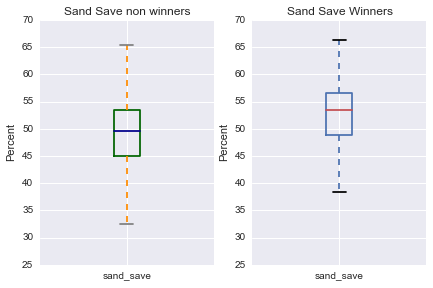

In [9]:
plt.subplot(121)
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
final['sand_save'][final['masters']==0].plot.box(color = color)
plt.title('Sand Save non winners')
plt.ylabel('Percent')

plt.subplot(122)
final['sand_save'][final['masters']==1].plot.box()
plt.ylim(25,70)
plt.title('Sand Save Winners')
plt.ylabel('Percent')

plt.tight_layout(pad=0.7, w_pad=0.7, h_pad=1.0)
plt.show()

Here we see that the players who finish in the top 10 in the masters had a higher median, lower, and upper quartile sand save percentage. However, it does not appear to be extremely significant.

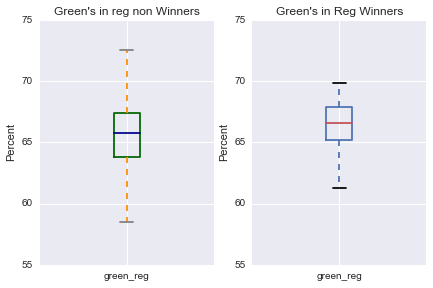

In [10]:
plt.subplot(121)
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
final['green_reg'][final['masters']==0].plot.box(color = color)
plt.ylim(55,75)
plt.title("Green's in reg non Winners")
plt.ylabel('Percent')


plt.subplot(122)
final['green_reg'][final['masters']==1].plot.box()
plt.ylim(55,75)
plt.title("Green's in Reg Winners")
plt.ylabel('Percent')

plt.tight_layout(pad=0.7, w_pad=0.7, h_pad=1.0)
plt.show()

For Green's in regulation, Again, we see there is a higher percentage for those who are in the top 10 of the Masters, but not by much.

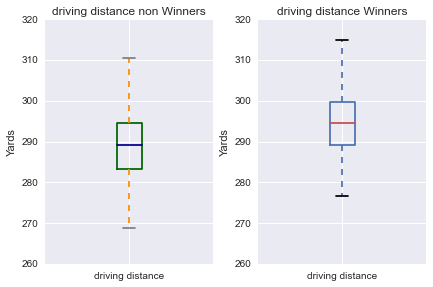

In [11]:
plt.subplot(121)
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
final['driving distance'][final['masters']==0].plot.box(color = color)
plt.ylim(260,320)
plt.title("driving distance non Winners")
plt.ylabel('Yards')

plt.subplot(122)
final['driving distance'][final['masters']==1].plot.box()
plt.ylim(260,320)
plt.title("driving distance Winners")
plt.ylabel('Yards')

plt.tight_layout(pad=0.7, w_pad=0.7, h_pad=1.0)
plt.show()

The players that finish in the top 10 of the masters have a longer median distance of drives, but not by much. One thing that is noticible here is that the player(s) with the longest drives are in the top 10 of the masters

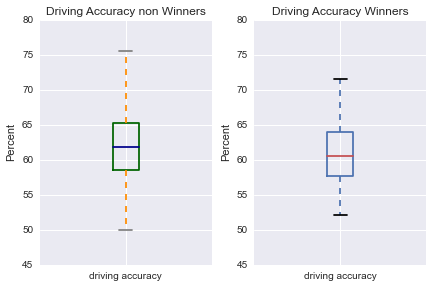

In [12]:
plt.subplot(121)
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
final['driving accuracy'][final['masters']==0].plot.box(color = color)
plt.ylim(45,80)
plt.title("Driving Accuracy non Winners")
plt.ylabel('Percent')


plt.subplot(122)
final['driving accuracy'][final['masters']==1].plot.box()
plt.ylim(45,80)
plt.title("Driving Accuracy Winners")
plt.ylabel('Percent')

plt.tight_layout(pad=0.7, w_pad=0.7, h_pad=1.0)
plt.show()

This is a very interesting graph. It shows that the players who finish in the top 10 of the masters actually tend to have a lower driving accuracy. The median is a couple percentage points lower and both quartiles are lower. This box plot coupled with the box plot above sends the message that the golfers who do well at the masters are willing to trade distance of drives for accuracy. 

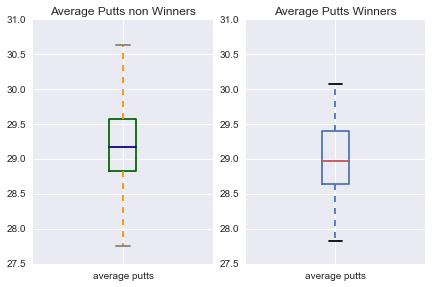

In [13]:
plt.subplot(121)
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
final['average putts'][final['masters']==0].plot.box(color = color)
#plt.ylim(45,80)
plt.title("Average Putts non Winners")


plt.subplot(122)
final['average putts'][final['masters']==1].plot.box()
plt.ylim(27.5,31)
plt.title("Average Putts Winners")

plt.tight_layout(pad=0.7, w_pad=0.7, h_pad=1.0)
plt.show()

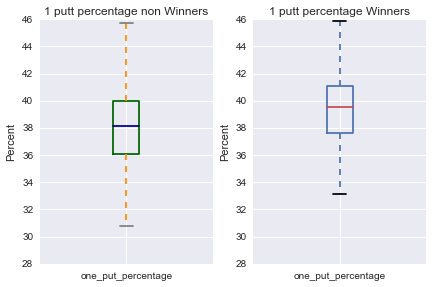

In [14]:
plt.subplot(121)
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
final['one_put_percentage'][final['masters']==0].plot.box(color = color)
#plt.ylim(45,80)
plt.title("1 putt percentage non Winners")
plt.ylabel('Percent')
plt.tight_layout(pad=0.7, w_pad=0.9, h_pad=1.0)

plt.subplot(122)
final['one_put_percentage'][final['masters']==1].plot.box()
plt.ylim(28,46)
plt.title("1 putt percentage Winners")
plt.ylabel('Percent')

plt.tight_layout(pad=0.7, w_pad=0.9, h_pad=1.0)
plt.show()


Again, there is not a significant difference between the two groups with the masters winning group being a little higher.

Big take-aways from these graphs:
- There does not appear to be any specific statistic that is drastically different between the two groups
- This probably means that being a little better on all the statistics is the key to performing well
- The group that does well in the Masters tend to have longer drives, but less accurate - so it appears that the trade off of distance for accuracy is important
- The bottom 15% of any one category usually does not appear in the masters group. 

# Analysis

In [315]:
import sklearn
from sklearn import linear_model
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier as forest
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import GradientBoostingRegressor as gbr
from xgboost import XGBClassifier as xgb
from sklearn.tree import DecisionTreeClassifier

First I split my data up into a test and train section

In [310]:
#cancer_data = datasets.load_breast_cancer()
y = final['masters'].astype(int)
x = final.drop(['name','masters','year'], 1)
x_train, x_test, y_train, y_test = model_selection.train_test_split(x,y,\
                                        train_size = .7, test_size = .3)

Since this is a classification model, I will start with one of the more basic classification methods - a logistic regression. 

## Logistic Regression

In [321]:
log_reg = linear_model.LogisticRegression(C=1./10)
#We fit the data on the training set
log_reg.fit(x_train,y_train)
#We obtain an accuracy score on the test set
print "Misclassification rate : ", 1 -sklearn.metrics.accuracy_score(y_test,log_reg.predict(x_test))

Misclassification rate :  0.033033033033


The logistic regression method is actually pretty accurate. The misclassificaion rate is only 3.3%. Which means the accuracy of this regression is about 96.7%. Now, I will try a couple of other models to determine if there is a model that will be more accurate. 

## Gradient Boosting

In [322]:
default_tree = gbc()
my_default = default_tree.fit(x_train, y_train)
y_pred = my_default.predict(x_test)
print "Misclassification rate : ", 1-accuracy_score(y_test,y_pred)

Misclassification rate :  0.039039039039


Using this gradient boosting method I can accurately predict if a player will finish in the top 10 of the Masters given their previous year stats about 96% of the time

## XG Boosting

In [323]:
default_tree = xgb()
my_treeD = default_tree.fit(x_train, y_train)
y_pred = my_treeD.predict(x_test)
print "Misclassification Rate : ", 1 - accuracy_score(y_test, y_pred)

Misclassification Rate :  0.033033033033


This XG Boost model was better than the Gradient boosting, but the same as the Logistic regression. 

Here we alter the XG Boost a little by changing a couple of the parameters:
- Change gamma, which is the minimum loss reduction required to make a further partition on a leaf node of the tree.
 from 0 to .15
- Change reg lambda, which is L2 regularization term on weights from 1 to .1 \
- Lastly, change  reg alpha, which is the L1 regularization term on weights from 0 to 2.5 

In [324]:
default_tree = xgb(gamma = 0.15, reg_lambda = 0.1, reg_alpha = 2.5)
my_treeD = default_tree.fit(x_train, y_train)
y_pred = my_treeD.predict(x_test)
print "Misclassification Rate : ", 1 - accuracy_score(y_test, y_pred)


Misclassification Rate :  0.03003003003


Using this XG boosting method I can accurately predict if a player will finish in the top 10 of the Masters given their previous year stats about 97% of the time

The XG Boosting model appears to be a little better model than the Gradient Boosting. So, now I have a model - XG boost. Thus, given a player and the basic statistics of their previous year on the tour I can predict if they will finish in the top 10 of the Masters next year. 

# Conclusion

While this is not a groundbreaking finding and the results are not the most useful, unless you are into sports betting, (which I am not nor do I promote) this is a fun tool to use for the average fan, (which I am). I am excited to use this tool for other tournaments besides the Masters and see how well I can do at predicting who will finish in the top 10. The next steps and future improvements on this project will be to predict the order of the top 10, but we will cross that bridge in another project.